In [1]:
import sys
sys.path.append("..")

In [3]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os

Using TensorFlow backend.


In [7]:
IMG_SIZE = 299

In [8]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(0)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.engine.training.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [ ]:
# load pre-trained model
K.clear_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))

sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")

In [9]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [10]:
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [11]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


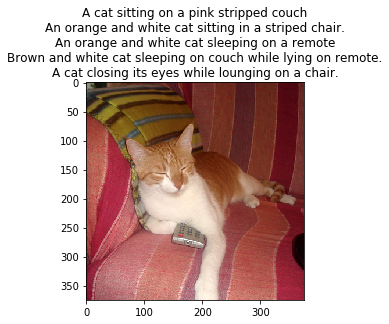

In [12]:
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [13]:
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [48]:
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

from collections import Counter

def generate_vocabulary(train_captions):
    flattened = [sentence for caption in train_captions for sentence in caption]
    flattened = split_sentence(' '.join(flattened))
    counter = Counter(flattened)
    vocab = [token for token, count in counter.items() if count>=5]
    vocab += [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions]
    return res

In [49]:
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [50]:
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [51]:
len(train_captions_indexed), len(val_captions_indexed)

(82783, 40504)

In [44]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    if not max_len:
        max_len = len(max(batch_captions, key=lambda x:len(x)))
    else:
        max_len = min(max_len, len(max(batch_captions, key=lambda x:len(x))))
    matrix = [[index for i, index in enumerate(caption[:max_len])] + [pad_idx]*(max(max_len-len(caption),0)) for caption in batch_captions]
    return np.array(matrix)

In [45]:
vocab['#PAD#']

1

In [46]:
batch_captions_to_matrix([[1, 2, 3], [4, 5]], 1)

array([[1, 2, 3],
       [4, 5, 1]])

RNN Text Generator

In [52]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [53]:
IMG_EMBED_SIZE

2048

In [54]:
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

In [55]:
class decoder:
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    sentences = tf.placeholder('int32', [None, None])
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, activation="elu")
    token_logits = L.Dense(len(vocab))
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    word_embeds = word_embed(sentences[:,:-1])
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))

    flat_ground_truth =tf.reshape(sentences[:,1:],[-1,])
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [56]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)
saver = tf.train.Saver()
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loop

In [59]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [60]:
train_captions_indexed[0][0]

[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0]

In [61]:
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    indx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings =images_embeddings[indx_batch]

    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[indx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [62]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100 

In [64]:
MAX_LEN = 20
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))



Epoch: 0, train loss: 4.242175040960312, val loss: 3.6565795063972475


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 1, train loss: 3.2990100343227384, val loss: 3.0837150168418885


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 2, train loss: 2.9829530620574953, val loss: 2.9358251428604127


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 3, train loss: 2.831128835439682, val loss: 2.8387770676612853


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 4, train loss: 2.745650892496109, val loss: 2.7855005478858947


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 5, train loss: 2.6849399945735932, val loss: 2.727706861495972


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 6, train loss: 2.6290882613658906, val loss: 2.6903075194358825


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 7, train loss: 2.587105666399002, val loss: 2.6581595444679262


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 8, train loss: 2.555795866727829, val loss: 2.615866193771362


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 9, train loss: 2.523505734205246, val loss: 2.611870334148407


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 10, train loss: 2.4955843594074247, val loss: 2.5967653226852416


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 11, train loss: 2.475707409143448, val loss: 2.586135456562042
Finished!


In [69]:
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.56175
Accuracy: 0.477690288714
Example 0
Predicted: a man in a in a in a #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man pouring wine from #UNK# for patrons #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man sitting to of #UNK# while on #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man tries out a bicycle powered blender #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [71]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [None, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [None], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /root/intro-to-dl/week6/weights


INFO:tensorflow:Restoring parameters from /root/intro-to-dl/week6/weights


In [72]:
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [73]:
def generate_caption(image, t=1, sample=False, max_len=20):
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player swinging a bat at a ball


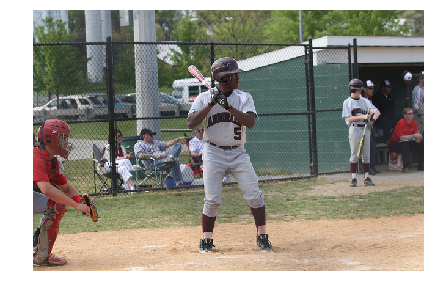

In [74]:
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a man on a skateboard is doing a trick


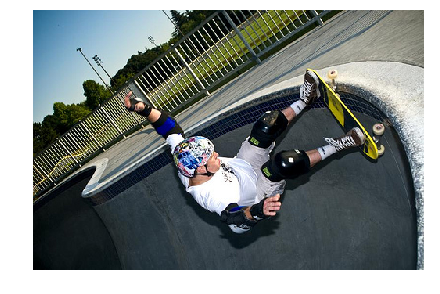

a street with a traffic light and a street sign


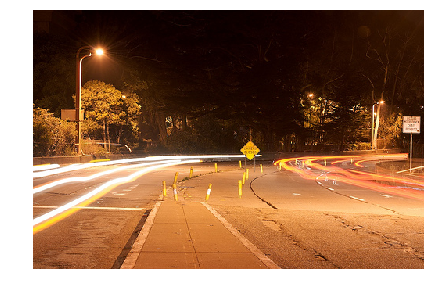

a man in a suit and tie standing next to a wall


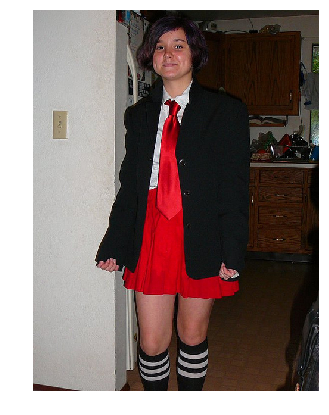

a pizza with a bunch of toppings on it


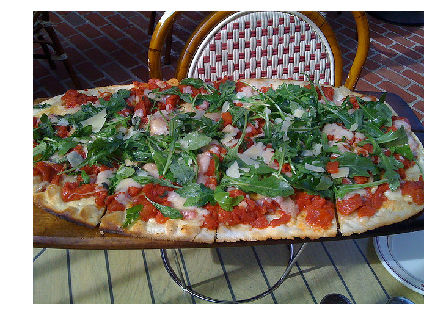

a table topped with a plate of food and a bowl of soup


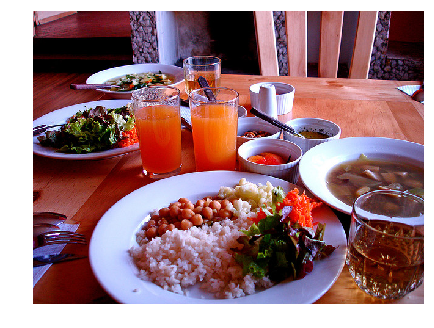

a woman in a white shirt playing tennis on a tennis court


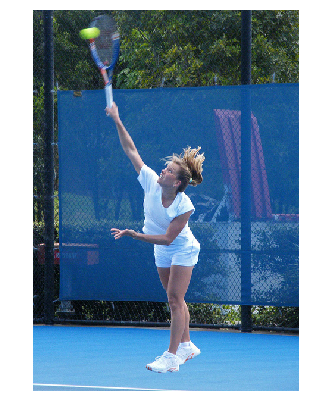

a woman is riding a horse in a field


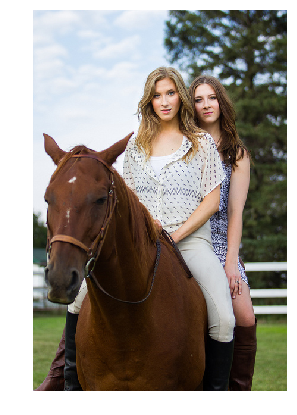

a stuffed bear sitting on a table with a stuffed bear


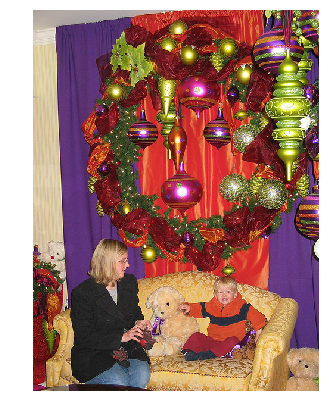

a man sitting at a table with a pizza


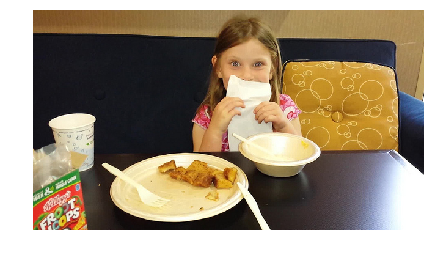

a woman in a black shirt is holding a cell phone


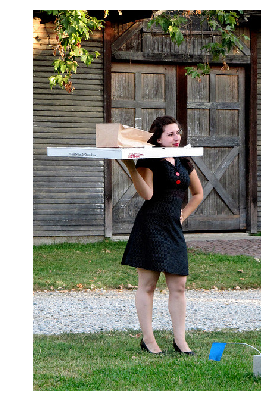

In [78]:
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)